# Inequality and Polarization: An Agent-Based Modeling Approach Using Eurostat Data

by:
- Kevin Heinrich, 11902941
- Matthias Hemmer, 11804194
- Marina Hofer, 12337819
- Christina Sophie Knes, 11902902

## Project Description

This project explores the relationship between regional income inequality and social polarization in Europe using agent-based modeling. Drawing on real-world data from Eurostat, including the Gini coefficient, at-risk-of-poverty rates and disposable income across NUTS-2 regions, we simulate how economic disparities might influence public opinion dynamics and social fragmentation.

We implement a modified Deffuant model, where agents interact and adjust their opinions based on income differences and local economic context. The model integrates heterogeneity in income, frustration levels, and opinion tolerance, creating a dynamic system that allows us to observe under which conditions polarization emerges.

Our main objectives are:
- To simulate opinion formation in a socioeconomically stratified population.
- To explore how varying levels of inequality and redistribution affect polarization.
- To identify regional vulnerability to polarization based on Eurostat indicators.

Through these simulations, we aim to provide insights into how economic structures may contribute to societal tensions, and how policy interventions might influence collective outcomes.

## Environment Setup

For the following project, **Python Version 3.13.5** was used. The recommended way would be to use a virtual environment when executing the cells in the jupyter notebook. To create a virtual environment, enter the following command:

- `python -m venv .venv`

Afterwards, you can select the python version of the virtual environment for the jupyter kernel.

The following libraries are required for this project:

### Agent-Based Modeling
- **`mesa`** –  A Python framework for building and analyzing agent-based models. Provides components for model structure, agents, data collection, and visualization.

### Data Access and APIs
- **`eurostat`** –  A Python interface to retrieve and process data from the Eurostat database, useful for accessing European statistics.

### Data Manipulation and Analysis
- **`numpy`** –  Fundamental package for numerical computations with support for multi-dimensional arrays and matrices.
- **`pandas`** –  Data manipulation and analysis library providing data structures like Series and DataFrame for handling structured data.

### Data Manipulation and Analysis
- **`matplotlib`** –  2D plotting library used to create static, interactive, and animated visualizations in Python.
- **`seaborn`** –  High-level interface for drawing attractive and informative statistical graphics built on top of matplotlib.

### Standard Library Modules
- **`pathlib`** – Object-oriented interface for working with filesystem paths, included in the Python standard library.


## PIP installations

To install the required libraries, run the following:

In [1]:
! pip install eurostat
! pip install numpy
! pip install pandas
! pip install mesa
! pip install scipy
! pip install matplotlib
! pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


## Import modules and define constants

For the structure of this project, we put every import and every constant in one cell each.

In [2]:
import eurostat
from mesa import Model, Agent, DataCollector
import numpy as np
from numpy.typing import NDArray
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

/home/kevin/Desktop/Uni/Master/Semester_02/CMSS_Project_Group_15/src/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Preprocessing constants
TARGET_AGE = "TOTAL"
TARGET_SEX = "T" # Total
TARGET_MEAN_INCOME_UNIT = "EUR" # Unit of measure for income: Euro
TARGET_MEAN_INCOME_INDIC = "MEI_E" # Income and living conditions indicator: Mean equivalised net income
TARGET_POVERTY_UNIT = "PC"
TARGET_POVERTY_INDIC = "LI_R_M60"
TARGET_HOUSING_INCOME_GROUP = "TOTAL"
TARGET_HOUSING_TYPE = "TOTAL"
TARGET_UNEMPLOYMENT_AGES = "Y15-74"
TARGET_UNEMPLOYMENT_UNIT = "PC_POP"

# Simulation constants
NUM_STEPS = 100
NUM_AGENTS_PER_REGION = 20
SEED = 15
SHIFT_RATE = 0.2
NOISE_STD = 0.05

## Set Seed for "random" calls

The following cell sets the seed for our "random" calls to allow the reproduction of the experiments.

In [4]:
np.random.seed(SEED)

## Define and create "results" directory

The next cell creates the "result" directory (only if it is not created so far) to store our result plots.

In [5]:
result_dir = Path.cwd().joinpath("results")
result_dir.mkdir(parents=True, exist_ok=True)

## 1. Read Eurostat data

### 1.1 Read data from API

Firstly, we download the necessary datasets via the `eurostat` API. In total, we use 5 datasets:

- **Mean and median income by age and sex** (code: ilc_di03)
- **Gini coefficient of equivalised disposable income by age** (code: ilc_di12)
- **At-risk-of-poverty rate by poverty threshold, age and sex** (code: ilc_li02)
- **Share of housing costs in disposable household income, by type of household and income group** (code: ilc_mded01)
- **Unemployment by sex and age - annual data** (code: une_rt_a)

In [6]:
df_orig_mean_median_income = eurostat.get_data_df("ilc_di03")
df_orig_gini_coefficient = eurostat.get_data_df("ilc_di12")
df_orig_at_risk_of_poverty = eurostat.get_data_df("ilc_li02")
df_orig_household_cost_shares = eurostat.get_data_df("ilc_mded01")
df_orig_unemployment_rate = eurostat.get_data_df("une_rt_a")

### 1.2 Fallback: Read data in local data directory

In case of a broken API or connection issues, we provided the possibility to use a local version of the datasets (Date of download: 05.07.2025).

In [7]:
data_path = Path.cwd().joinpath("data")

if df_orig_mean_median_income is None:
    df_orig_mean_median_income = pd.read_csv(data_path.joinpath("mean_and_median_income_ilc_di03.csv"))
    
if df_orig_gini_coefficient is None:
    df_orig_gini_coefficient = pd.read_csv(data_path.joinpath("gini_coefficient_ilc_di12.csv"))
    
if df_orig_at_risk_of_poverty is None:
    df_orig_at_risk_of_poverty = pd.read_csv(data_path.joinpath("at_risk_of_poverty_ilc_li02.csv"))
    
if df_orig_household_cost_shares is None:
    df_orig_household_cost_shares = pd.read_csv(data_path.joinpath("household_cost_shares_ilc_mded01.csv"))
    
if df_orig_unemployment_rate is None:
    df_orig_unemployment_rate = pd.read_csv(data_path.joinpath("unemployment_rate_une_rt_a.csv"))

## 2. Preprocess data

In the following cells, we prepare the preprocessing in terms of defining relevant columns and preprocessing functions. And the subchapters, we preprocess the data such that we keep only relevant years (2015-2024) and such that we have a consistent set of regions (all datasets have to store the same regions) to make simulations as easy as possible.

In [8]:
relevant_years = [str(year) for year in range(2015, 2025)] 
relevant_columns = ["geo"] + relevant_years
non_eu_entities = ['EU27_2020', 'EA20']

In [9]:
def do_preprocessing_steps(df: pd.DataFrame, filter_options: dict[str, str], convert_percentage: bool) -> pd.DataFrame:
    df = df.rename(columns={"geo\\TIME_PERIOD": "geo"})
    df = df[~df["geo"].isin(non_eu_entities)]
    
    for k, v in filter_options.items():
        df = df[df[k] == v]
    
    df = df[relevant_columns]
    df = df.dropna()
    
    if not convert_percentage:
        return df
    
    for year in relevant_years: 
        df[year] = df[year].div(100).round(4)
        
    return df

### 2.1 Preprocess "Mean and Median income" Dataset

In [10]:
filter_options = {"sex": TARGET_SEX, "age": TARGET_AGE, "unit": TARGET_MEAN_INCOME_UNIT, "indic_il": TARGET_MEAN_INCOME_INDIC}

df_processed_mean_median_income = df_orig_mean_median_income.copy(deep=True)
df_processed_mean_median_income = do_preprocessing_steps(df_processed_mean_median_income, filter_options, False)

### 2.2 Preprocess "Gini Coefficient" Dataset

In [11]:
filter_options = {"age": TARGET_AGE}

df_processed_gini_coefficient = df_orig_gini_coefficient.copy(deep=True)
df_processed_gini_coefficient = do_preprocessing_steps(df_processed_gini_coefficient, filter_options, True)

### 2.3 Preprocess "At-risk-of-poverty" Dataset

In [12]:
filter_options = {"sex": TARGET_SEX, "age": TARGET_AGE, "unit": TARGET_POVERTY_UNIT, "indic_il": TARGET_POVERTY_INDIC}

df_processed_at_risk_of_poverty = df_orig_at_risk_of_poverty.copy(deep=True)
df_processed_at_risk_of_poverty = do_preprocessing_steps(df_processed_at_risk_of_poverty, filter_options, True)

### 2.4 Preprocess "Housing Cost" Dataset

In [13]:
filter_options = {"incgrp": TARGET_HOUSING_INCOME_GROUP, "hhtyp": TARGET_HOUSING_TYPE}

df_processed_household_cost_shares = df_orig_household_cost_shares.copy(deep=True)
df_processed_household_cost_shares = do_preprocessing_steps(df_processed_household_cost_shares, filter_options, True)

### 2.5 Preprocess "Unemployment" Dataset

In [14]:
filter_options = {"age": TARGET_UNEMPLOYMENT_AGES, "sex": TARGET_SEX, "unit": TARGET_UNEMPLOYMENT_UNIT}

df_processed_unemployment_rate = df_orig_unemployment_rate.copy(deep=True)
df_processed_unemployment_rate = do_preprocessing_steps(df_processed_unemployment_rate, filter_options, True)

### 2.6 Calculate intersection of regions between all datasets


In [15]:
distinct_regions_mean_median_income = set(df_processed_mean_median_income["geo"].unique())
distinct_regions_gini_coefficient = set(df_processed_gini_coefficient["geo"].unique())
distinct_regions_risk_of_poverty = set(df_processed_at_risk_of_poverty["geo"].unique())
distinct_regions_household_cost_shares = set(df_processed_household_cost_shares["geo"].unique())
distinct_regions_unemployment_rate = set(df_processed_unemployment_rate["geo"].unique())

shared_regions = distinct_regions_mean_median_income & distinct_regions_gini_coefficient & distinct_regions_household_cost_shares & distinct_regions_risk_of_poverty & distinct_regions_unemployment_rate

df_processed_mean_median_income = df_processed_mean_median_income[df_processed_mean_median_income["geo"].isin(shared_regions)].copy()
df_processed_gini_coefficient = df_processed_gini_coefficient[df_processed_gini_coefficient["geo"].isin(shared_regions)].copy()
df_processed_at_risk_of_poverty = df_processed_at_risk_of_poverty[df_processed_at_risk_of_poverty["geo"].isin(shared_regions)].copy()
df_processed_household_cost_shares = df_processed_household_cost_shares[df_processed_household_cost_shares["geo"].isin(shared_regions)].copy()
df_processed_unemployment_rate = df_processed_unemployment_rate[df_processed_unemployment_rate["geo"].isin(shared_regions)].copy()

## 3. Define Dataframe merge method

For simplicity, we define a merging function to combine multiple dataframes at ones. The all have to share one common key.

In [16]:
def merge_dataframes(dfs: list[pd.DataFrame], key: str) -> pd.DataFrame:
    if len(dfs) == 0:
        return pd.DataFrame()
    
    result_df = dfs[0]
    for df in dfs[1:]:
        result_df = result_df.merge(df, left_on=key, right_on=key)
        
    return result_df

## 4. Generate Synthetic Income Distribution

With help of the average income and gini coefficient of each region, we calculate synthetic incomes via the log-normal distribution

In [17]:
# See: https://en.wikipedia.org/wiki/Log-normal_distribution
def generate_synthetic_income_distribution(avg_income: float, gini: float, n: int = NUM_AGENTS_PER_REGION) -> NDArray[np.float64]:
    sigma = gini * 1.5  # empirical tuning -> add more variance 
    mu = np.log(avg_income) - (sigma ** 2) / 2
    return np.random.lognormal(mean=mu, sigma=sigma, size=n)

In [18]:
income_distributions = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    df_merged = merge_dataframes([mean_incomes, gini_coefficients], key="geo")
    
    distributions_by_year = {}
    for _, row in df_merged.iterrows():
        region = row["geo"]
        mean_income = row["mean"]
        gini = row["gini"]
        distributions_by_year[region] = generate_synthetic_income_distribution(mean_income, gini)
    
    income_distributions[year] = distributions_by_year

## 5. Create the Agent and Model Classes

### 5.1 PersonAgent

TODO: Description

In [19]:
class PersonAgent(Agent):
    def __init__(self,
                model: Model,
                region: str,
                income: float,
                gini: float,
                opinion: float,
                household_cost_share: float | None,
                unemployment_rate: float,
                poverty_flag: bool = False,
                ) -> None:
        super().__init__(model)
        self.region = region
        self.income = income
        self.gini = gini
        self.opinion = opinion
        self.effective_income = income
        if household_cost_share is not None:
            self.effective_income = income * (1 - household_cost_share)
        self.poverty_flag = poverty_flag
        self.unemployment_rate = unemployment_rate

        region_avg = self.model.region_data[self.model.region_data["geo"] == region]["mean"].values[0]
        self.compute_frustration(region_avg)
        
        # Tolerance: more frustration → less tolerance
        self.tolerance = max(0.01, 0.5 * (1 - self.frustration))
        
    def compute_frustration(self, region_avg: float) -> None:
        # Frustration increases if income is below region average or in poverty
        self.frustration = float(max(0, (region_avg - self.effective_income) / region_avg))
        self.frustration = float(min(1, self.frustration + self.unemployment_rate  * 0.5))
        if self.poverty_flag:
            self.frustration = float(min(1, self.frustration + 0.2))  # amplify if in poverty

    def step(self) -> None:
        partner: PersonAgent = self.random.choice(self.model.agents)
        delta = abs(self.opinion - partner.opinion)
        
        noise1 = self.random.gauss(0, NOISE_STD)
        noise2 = self.random.gauss(0, NOISE_STD)
        
        if delta < self.tolerance and delta < partner.tolerance:
            mu = self.model.mu
            opinion1, opinion2 = self.opinion, partner.opinion
            self.opinion += mu * (opinion2- opinion1) + noise1
            partner.opinion += mu * (opinion1 - opinion2) + noise2
            # Ensure to stay in a valid range
            self.opinion = min(max(self.opinion, 0), 1)
            partner.opinion = min(max(partner.opinion, 0), 1)

### 5.2 InequalityModel

TODO: Description

In [20]:
class InequalityModel(Model):
    def __init__(self, region_data: pd.DataFrame, synthetic_incomes: dict[str, list[float]], agents_per_region: int, mu: float):
        super().__init__(seed=SEED)
        self.mu = mu
        self.region_data = region_data

        self.init_agents(synthetic_incomes, agents_per_region)

        self.datacollector = DataCollector(
            model_reporters={
                "OpinionVariance": lambda m: np.var([a.opinion for a in m._agents]).round(4),
                "OpinionMean": lambda m: np.mean([a.opinion for a in m._agents]).round(4),
                "FrustrationVariance": lambda m: np.var([a.frustration for a in m._agents]).round(4),
                "FrustrationMeanByRegion": lambda m: {
                                                    region: np.mean([a.frustration for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                },
                "FrustrationMean": lambda m: np.mean([a.frustration for a in m._agents]).round(4),
                "poverty_mean": lambda m: np.mean([a.poverty_flag for a in m._agents]),
                "PovertyMeanByRegion": lambda m: {
                                                    region: np.mean([a.poverty_flag for a in m._agents if a.region == region])
                                                    for region in set(a.region for a in m._agents)
                                                }
            },
            agent_reporters={
                "Opinion": "opinion",
                "Region": "region",
                "Frustration": "frustration"
            }
        )


    def init_agents(self, synthetic_incomes: dict[str, list[float]], agents_per_region: int):
        for _, row in self.region_data.iterrows():
            region = row['geo']
            gini = row['gini']
            household_cost_share = row["household_cost_share"] if "household_cost_share" in row.index else None
            poverty_rate = row["at_risk_of_poverty"]
            unemployment_rate = row["unemployment_rate"]

            for i in range(agents_per_region):
                income = synthetic_incomes[region][i]
                opinion = np.random.uniform(0, 1)
                poverty_flag = np.random.rand() < poverty_rate
                
                PersonAgent(self, region, income, gini, opinion, household_cost_share, unemployment_rate, poverty_flag)
                

    def run_simulation(self, number_of_steps: int) -> tuple[pd.DataFrame, pd.DataFrame]:
        for _ in range(number_of_steps):
            self.agents.do("step")
        self.datacollector.collect(self)
        model_df = self.datacollector.get_model_vars_dataframe()
        agent_df = self.datacollector.get_agent_vars_dataframe()
        
        return model_df, agent_df

## 6. Run simulations

### 6.1 Run model with all factors

In [21]:
mean_frustrations_over_years_all_factors = {}
mean_frustrations_dict_over_years_all_factors = {}
mean_opinions_over_years_all_factors = {}
poverty_dict_all_factors = {}
poverty_mean_all_factors = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    at_risk_of_poverty = df_processed_at_risk_of_poverty[["geo", year]].rename(columns={year: "at_risk_of_poverty"})
    household_costs = df_processed_household_cost_shares[["geo", year]].rename(columns={year: "household_cost_share"})
    unemployment_rate = df_processed_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = merge_dataframes([mean_incomes, gini_coefficients, at_risk_of_poverty, household_costs, unemployment_rate], key="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model_df, agent_df = model.run_simulation(NUM_STEPS)
    
    mean_frustrations_over_years_all_factors[year] = model_df["FrustrationMean"].values[0]
    mean_frustrations_dict_over_years_all_factors[year] = model_df["FrustrationMeanByRegion"]
    mean_opinions_over_years_all_factors[year] = model_df["OpinionMean"].values[0]
    poverty_mean_all_factors[year] = model_df["poverty_mean"].values[0]
    poverty_dict_all_factors[year] = model_df["PovertyMeanByRegion"]

### 6.2 Run model and exclude only household share costs

In [22]:
mean_frustrations_over_years_exclude_household_share = {}
mean_frustrations_dict_over_years_exclude_household_share = {}
mean_opinions_over_years_exclude_household_share = {}
poverty_dict_exclude_household_share = {}
poverty_mean_exclude_household_share = {}

for year in relevant_years:
    mean_incomes = df_processed_mean_median_income[["geo", year]].rename(columns={year: "mean"})
    gini_coefficients = df_processed_gini_coefficient[["geo", year]].rename(columns={year: "gini"})
    at_risk_of_poverty = df_processed_at_risk_of_poverty[["geo", year]].rename(columns={year: "at_risk_of_poverty"})
    unemployment_rate = df_processed_unemployment_rate[["geo", year]].rename(columns={year: "unemployment_rate"})
    df_region_data = merge_dataframes([mean_incomes, gini_coefficients, at_risk_of_poverty, unemployment_rate], key="geo")

    model = InequalityModel(region_data=df_region_data, synthetic_incomes=income_distributions[year], agents_per_region=NUM_AGENTS_PER_REGION, mu=SHIFT_RATE)
    model_df, agent_df = model.run_simulation(NUM_STEPS)
    
    mean_frustrations_over_years_exclude_household_share[year] = model_df["FrustrationMean"].values[0]
    mean_frustrations_dict_over_years_exclude_household_share[year] = model_df["FrustrationMeanByRegion"]
    mean_opinions_over_years_exclude_household_share[year] = model_df["OpinionMean"].values[0]
    poverty_mean_exclude_household_share[year] = model_df["poverty_mean"].values[0]
    poverty_dict_exclude_household_share[year] = model_df["PovertyMeanByRegion"]

## 7. Compare mean frustrations over years with all factors and when excluding household cost share

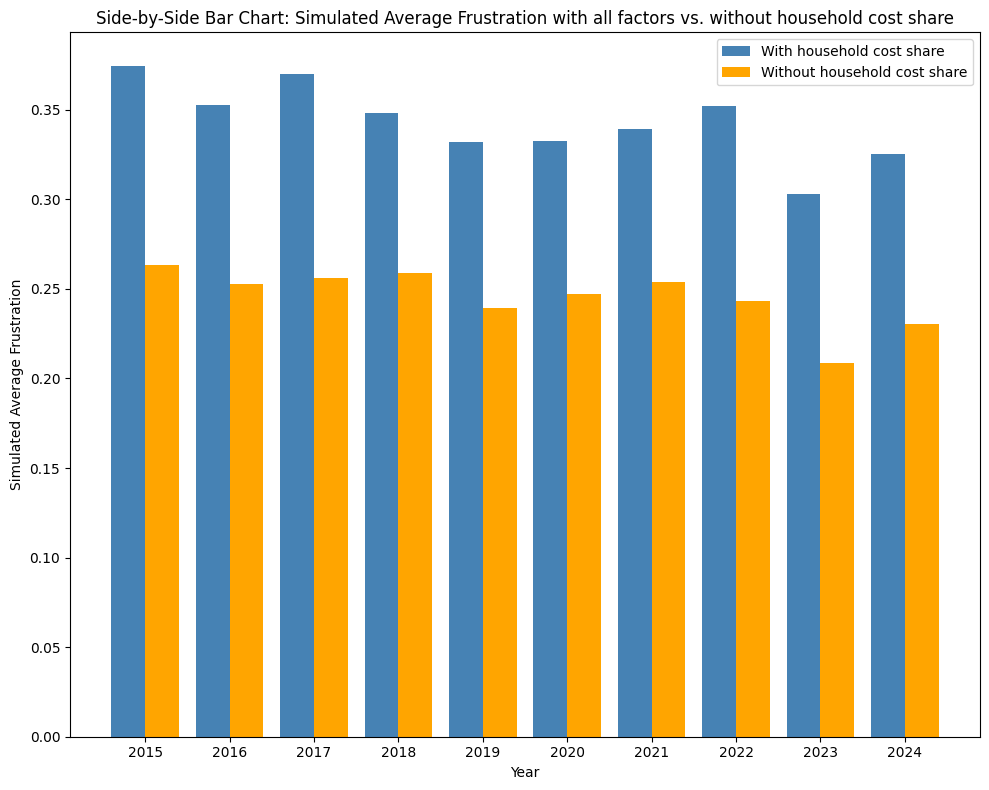

In [23]:
x = np.arange(len(relevant_years))  # numeric positions for shared years
bar_width = 0.4

# Plot bars
plt.figure(figsize=(10, 8))
plt.bar(x - bar_width/2, list(mean_frustrations_over_years_all_factors.values()), width=bar_width, label='With household cost share', color='steelblue')
plt.bar(x + bar_width/2, list(mean_frustrations_over_years_exclude_household_share.values()), width=bar_width, label='Without household cost share', color='orange')

# Axis labels and ticks
plt.xticks(x, relevant_years)
plt.xlabel("Year")
plt.ylabel("Simulated Average Frustration")
plt.title("Side-by-Side Bar Chart: Simulated Average Frustration with all factors vs. without household cost share")
plt.legend()
plt.tight_layout()
plt.show()

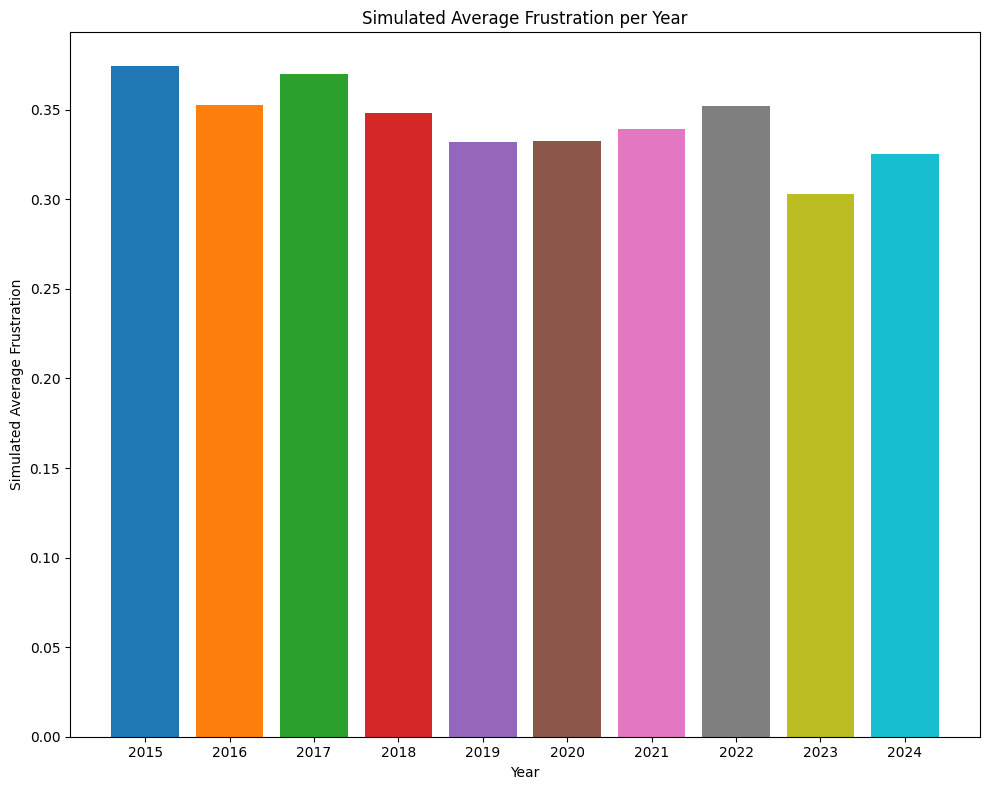

In [24]:
years = list(mean_frustrations_over_years_all_factors.keys())
frustration_means = list(mean_frustrations_over_years_all_factors.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Average Frustration")
plt.title("Simulated Average Frustration per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_frustrations_over_years.pdf"), format="pdf")
plt.show()

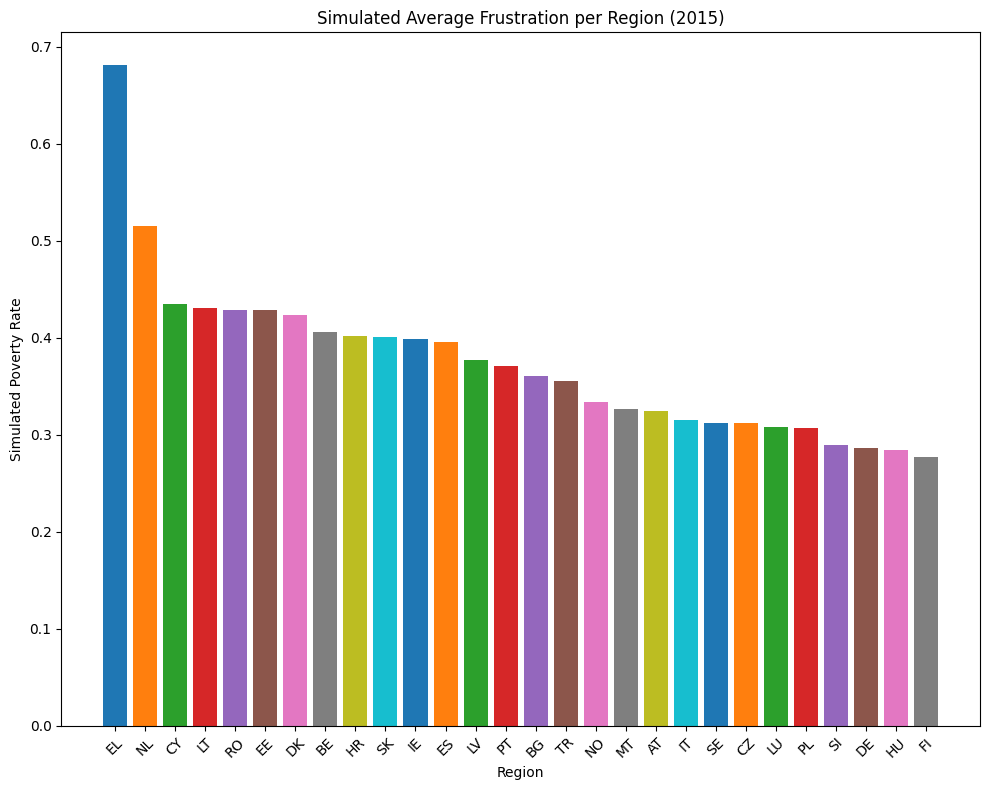

In [25]:
year = '2015'
frustration_series = mean_frustrations_dict_over_years_all_factors[year]
frustration_data = frustration_series.iloc[0]

sorted_frustration = dict(sorted(frustration_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_frustration.keys())
frustration_mean = list(sorted_frustration.values())

plt.figure(figsize=(10, 8))
plt.bar(region, frustration_mean, color=sns.color_palette("tab10", len(region)))
plt.xlabel("Region")
plt.ylabel("Simulated Poverty Rate")
plt.title(f"Simulated Average Frustration per Region ({year})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_frustration_by_region_{year}.pdf"), format="pdf")
plt.show()

## 8. Plot mean opinions over years

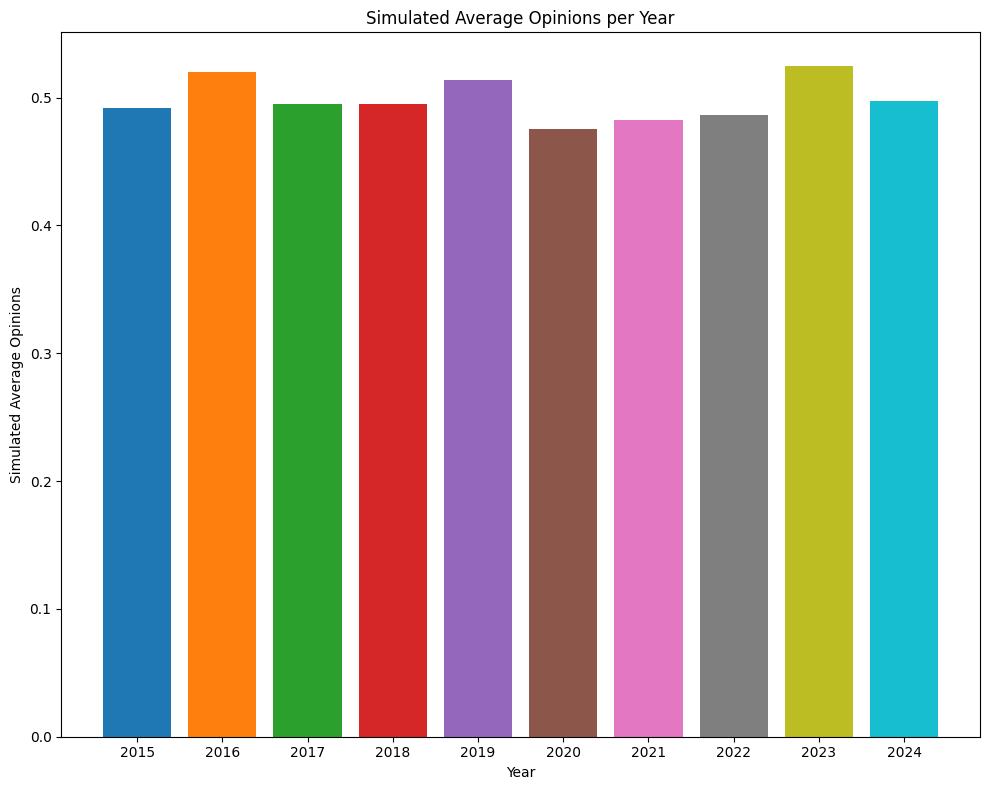

In [26]:
years = list(mean_opinions_over_years_all_factors.keys())
frustration_means = list(mean_opinions_over_years_all_factors.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Average Opinions")
plt.title("Simulated Average Opinions per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_opinions_over_years.pdf"), format="pdf")
plt.show()

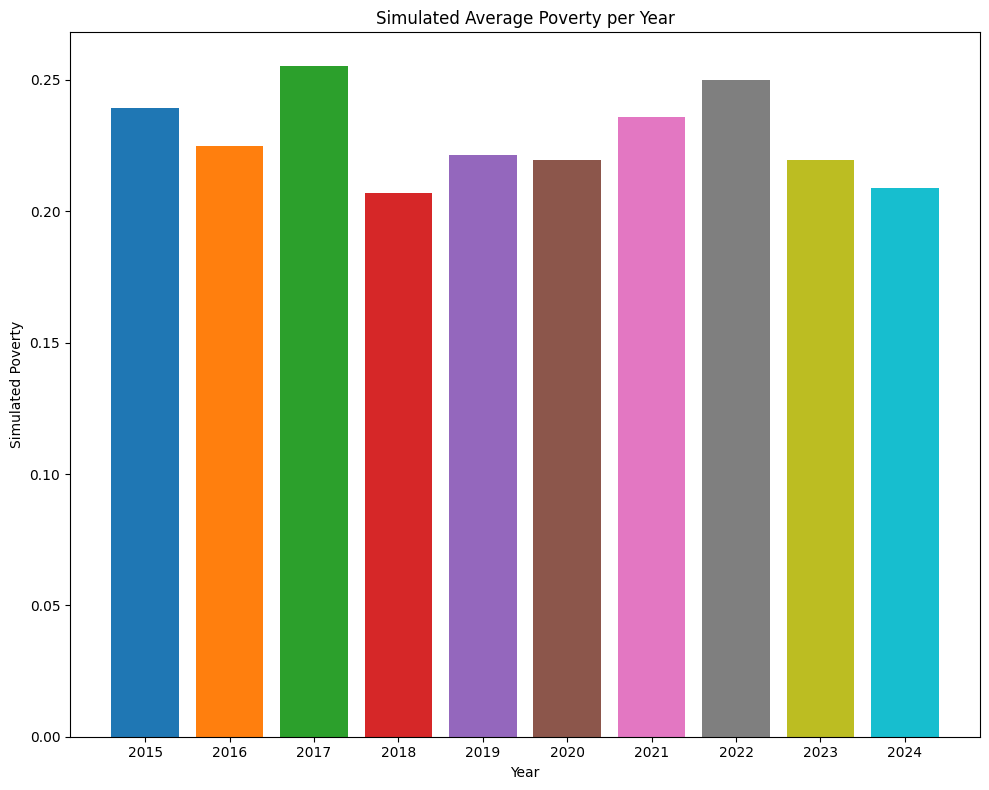

In [27]:
years = list(mean_opinions_over_years_all_factors.keys())
frustration_means = list(poverty_mean_all_factors.values())

palette = sns.color_palette("tab10", len(years))
colors = palette.as_hex()

plt.figure(figsize=(10, 8))
plt.bar(years, frustration_means, color=colors)
plt.xlabel("Year")
plt.ylabel("Simulated Poverty")
plt.title("Simulated Average Poverty per Year")
plt.tight_layout()
plt.savefig(result_dir.joinpath("mean_poverty_over_years.pdf"), format="pdf")
plt.show()

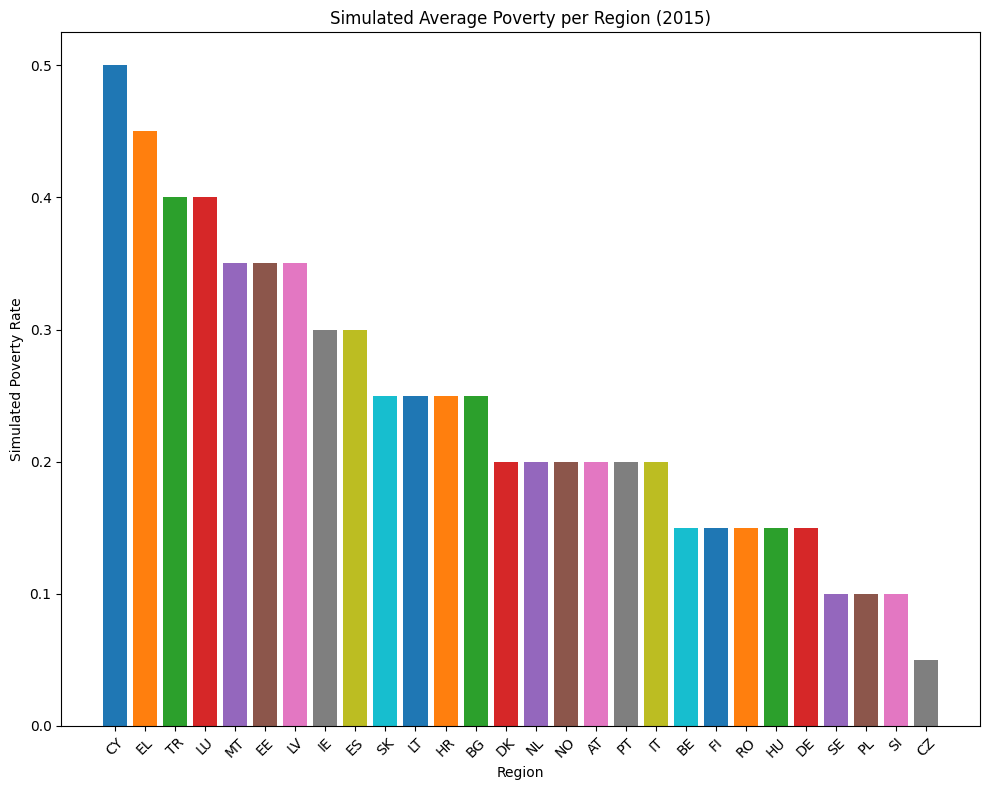

In [28]:
year = '2015'
poverty_series = poverty_dict_all_factors[year]
poverty_data = poverty_series.iloc[0]

sorted_poverty = dict(sorted(poverty_data.items(), key=lambda item: item[1], reverse=True))

region = list(sorted_poverty.keys())
poverty_mean = list(sorted_poverty.values())

plt.figure(figsize=(10, 8))
plt.bar(region, poverty_mean, color=sns.color_palette("tab10", len(region)))
plt.xlabel("Region")
plt.ylabel("Simulated Poverty Rate")
plt.title(f"Simulated Average Poverty per Region ({year})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(result_dir.joinpath(f"mean_poverty_by_region_{year}.pdf"), format="pdf")
plt.show()

/tmp/ipykernel_36700/882919478.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_poverty_2015, x=year, y="geo", palette="viridis")


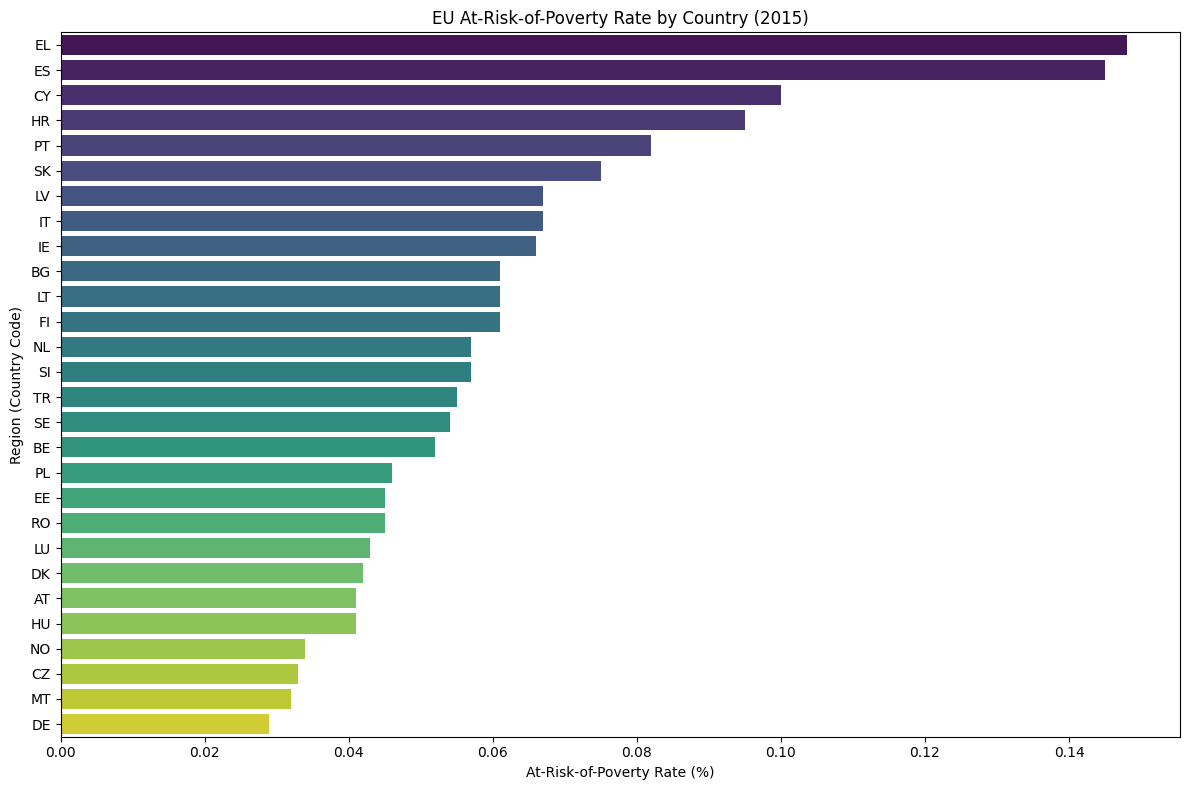

In [29]:
df_poverty_2015 = df_processed_unemployment_rate[["geo", year]].dropna().sort_values(year, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=df_poverty_2015, x=year, y="geo", palette="viridis")
plt.xlabel("At-Risk-of-Poverty Rate (%)")
plt.ylabel("Region (Country Code)")
plt.title(f"EU At-Risk-of-Poverty Rate by Country ({year})")
plt.tight_layout()
plt.show()